In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [64]:
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
from statsmodels.tsa.holtwinters import ExponentialSmoothing

In [65]:
data = pd.read_csv('/content/drive/MyDrive/TSA_BDA_2024/Lab4/Retail_sales_of_electricity_United_States_monthly.csv', skiprows=4)

In [66]:
data.dropna(inplace=True)
data['DatePart'] = pd.to_datetime(data['Month'], format='%b %Y', errors='coerce')
data.rename(columns = {"DatePart" : "Date"}, inplace=True)
data.set_index("Date", inplace=True)
data.drop(columns=["Month"], inplace=True)

In [67]:
data

,all sectors million kilowatthours
Date,
2022-10-01,292257.74617
2022-09-01,297195.94414
2022-08-01,340543.84071
2022-07-01,389626.28230
2022-06-01,389214.17473
...,...
2001-04-01,264490.49166
2001-03-01,254390.93545
2001-02-01,269298.40142


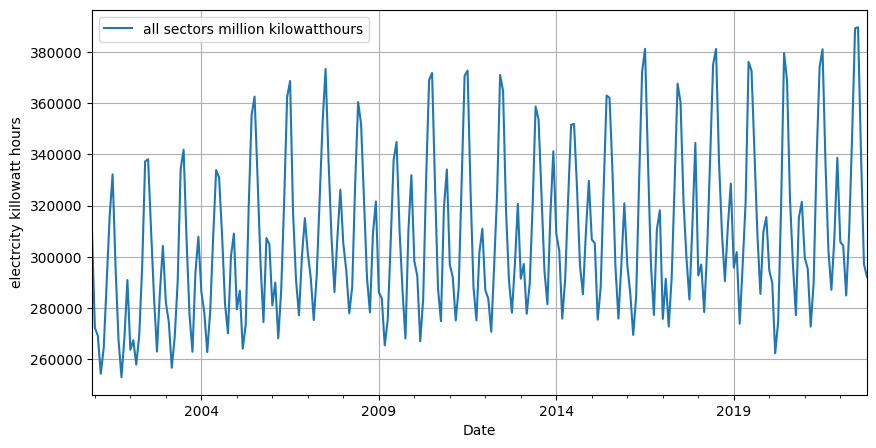

In [68]:
data.plot(figsize=(10,5), grid=True)
plt.ylabel("electrcity killowatt hours")
plt.show()

In [69]:
data.sort_index(inplace=True)
data

,all sectors million kilowatthours
Date,
2000-12-01,310816.06880
2001-01-01,272334.73804
2001-02-01,269298.40142
2001-03-01,254390.93545
2001-04-01,264490.49166
...,...
2022-06-01,389214.17473
2022-07-01,389626.28230
2022-08-01,340543.84071


Sliding window for training and testing over multiple iterations

In [114]:
from statsmodels.tools.sm_exceptions import ConvergenceWarning
import warnings
warnings.simplefilter('ignore', ConvergenceWarning)

In [71]:
data.index.freq='MS'

In [104]:
from sklearn.metrics import mean_squared_error , mean_absolute_error
num_repeats = 20
length = len(data)
min_train_points = 120
max_test_points = 12
move_window_by = 7

In [105]:
fits = {"Add-Add": ["add", "add"], "Add-Mul": ["add", "mul"], "Mul-Add": ["mul", "add"], "Mul-Mul": ["mul", "mul"]}

In [112]:
mse_score_per_fit = []
mae_score_per_fit = []
sse_score_per_fit = []
for fit_type, value in fits.items() :
    mse_values = []
    mae_values = []
    sse_values = []
    for j in range(num_repeats):

        train_window_start = j * move_window_by
        train_window_end = min(train_window_start + min_train_points, length)
        test_window_start = train_window_end
        test_window_end = min(test_window_start + max_test_points, length)

        X_train = data[train_window_start:train_window_end]
        X_test = data[test_window_start:test_window_end]

        fit = ExponentialSmoothing(
            X_train,
            seasonal_periods=12,
            trend= value[0],
            seasonal= value[1],
            initialization_method="estimated",
        ).fit()
        fcast = fit.forecast(len(X_test))
        sse_val = fit.sse
        sse_values.append(sse_val)
        mse = mean_squared_error(X_test, fcast.values)
        mse_values.append(mse)
        mae = mean_absolute_error(X_test, fcast.values)
        mae_values.append(mse)
    average_mse = np.mean(np.array(mse_values))
    average_mae = np.mean(np.array(mae_values))
    average_sse = np.mean(np.array(sse_values))
    mse_score_per_fit.append(average_mse)
    mae_score_per_fit.append(average_mae)
    sse_score_per_fit.append(average_sse)


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/holtwinters/model.py:83: RuntimeWarning: overflow encountered in matmul
  return err.T @ err


In [107]:
for index, key in enumerate(fits.keys()):
    print(f"For {key}, average MSE score after {num_repeats} repitions is {mse_score_per_fit[index]}")

For Add-Add, average MSE score after 20 repitions is 133518874.42583866
For Add-Mul, average MSE score after 20 repitions is 379242733.4344953
For Mul-Add, average MSE score after 20 repitions is 148913585.19587404
For Mul-Mul, average MSE score after 20 repitions is 3.5335147762052224e+28


In [108]:
for index, key in enumerate(fits.keys()):
    print(f"For {key}, average MAE score after {num_repeats} repitions is {mae_score_per_fit[index]}")

For Add-Add, average MAE score after 20 repitions is 133518874.42583866
For Add-Mul, average MAE score after 20 repitions is 379242733.4344953
For Mul-Add, average MAE score after 20 repitions is 148913585.19587404
For Mul-Mul, average MAE score after 20 repitions is 3.5335147762052224e+28


In [109]:
for index, key in enumerate(fits.keys()):
    print(f"For {key}, average SSE score after {num_repeats} repitions is {sse_score_per_fit[index]}")

For Add-Add, average SSE score after 20 repitions is 5743152192.527533
For Add-Mul, average SSE score after 20 repitions is 184970424649.61957
For Mul-Add, average SSE score after 20 repitions is 5749027039.279264
For Mul-Mul, average SSE score after 20 repitions is 100655492282113.38


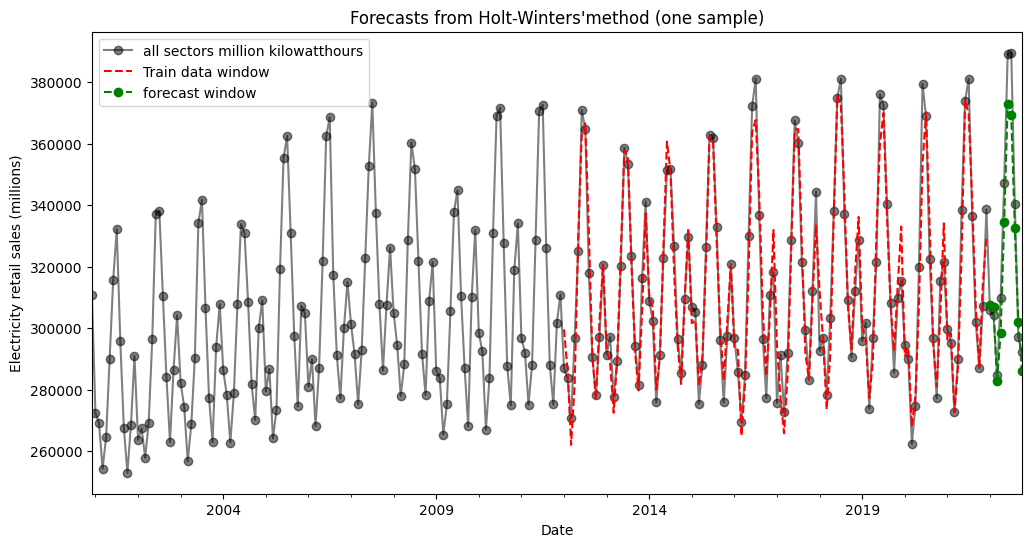

In [110]:
ax = data.plot(
    figsize=(12, 6),
    marker="o",
    color="black",
    title="Forecasts from Holt-Winters'method (one sample)",
    alpha=0.5,
    label="actual values"
)
ax.set_ylabel("Electricity retail sales (millions)")
fit.fittedvalues.plot(ax=ax, style="--", color="red", label="Train data window")
fit.forecast(len(X_test)).rename("forecast window").plot(
    ax=ax, style="--",  marker="o", color="green", legend=True
)
plt.legend()
plt.show()